# Stereo Estimation


In [2]:
!pip install opencv-python


     ---------------------------------------- 38.6/38.6 MB 1.7 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


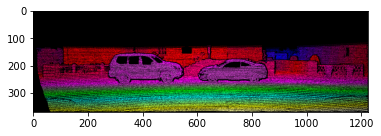

In [4]:
import matplotlib.pyplot as plt
from util import *

# load the data
leftI = load_image('data/000005_10_left_color.png')
rightI = load_image('data/000005_10_right_color.png')
dispI_gt = load_disp('data/000005_10_gt.png')
max_disp = np.max(dispI_gt)

plt.imshow(disp_to_color(dispI_gt, max_disp))

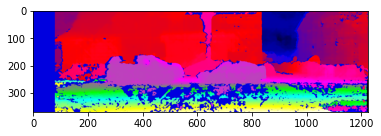

In [5]:
NUM_DISP = 80
WINDOW_SIZE = 7

stereo = cv2.StereoSGBM_create(minDisparity = 0,
                               numDisparities = NUM_DISP,
                               blockSize = WINDOW_SIZE,
                               P1 = 8*3*WINDOW_SIZE**2,
                               P2 = 32*3*WINDOW_SIZE**2,
                               disp12MaxDiff = 1,
                               uniquenessRatio = 10,
                               speckleWindowSize = 100,
                               speckleRange = 32)

dispI_est = stereo.compute(leftI, rightI).astype(np.float32) / 16.0
max_disp = np.max(dispI_est)

plt.imshow(disp_to_color(dispI_est, max_disp))

In [8]:
### KITTI parameters ###
f = 718.86
cx = 607.19
cy = 185.22
B = 0.537

# triangulate 3D Points
all_colors = cv2.cvtColor(leftI, cv2.COLOR_BGR2RGB)
height, width = leftI.shape[:2]

def triangulate(dispI, fn):
    points = []
    colors = []

    # compute the 3D points for the given disparity image and their corresponding colors
    # by implementing triangulation (back-projection)
    
    for i in range(dispI.shape[0]):
        for j in range(dispI.shape[1]):
            disparity=dispI[i,j]
            
            if disparity==0: #i did without this first, but got divide by 0 warning
                continue
                
            depth=B*f/disparity
            x=(i-cx)*depth/f
            y=(j-cy)*depth/f
            z=depth
            points.append([x,y,z])
            colors.append(all_colors[i,j])

    points = np.array(points)
    colors = np.array(colors)
    write2ply(points, colors, fn)
    
triangulate(dispI_gt, 'out/pts_gt.ply')
triangulate(dispI_est, 'out/pts_est.ply')

print('done!')

done!


Visualize the 3D point clouds using MeshLab or Open3D. Note that you might have to rotate the point cloud a little bit until you can make sense of it, especially with the estimated disparity map where there are outliers.

**Bonus**: Implement the outlier ratio metric of the KITTI to evaluate the estimation quantitatively.

In [16]:
threshold=3 #in class we said threshold for KITTI is 3 pixels or %5

def outlier_ratio(dispI_est,dispI_gt,threshold):
    error=np.abs(dispI_gt-dispI_est)
    mask=error>threshold
    ratio=np.sum(mask)/mask.size*100
    return ratio

outlier_ratio(dispI_est,dispI_gt, threshold)

65.33640492041796